UmPy current uses 4 python files which contain the function needed to do the full UnitMatch pipeline, with some helped function to make it easier/analyse it. 
util.py has folder for easy reading in files, and handling data such as session id's and evaluating the outputs.
Param_fun.py has all the funtion used in extracting the parameters from the average wavefunctions
metrics_fun.py hass all the funtion used for getting the Metric (e.g scores) as well as drift correction
Bayes_fun.py has the function necessary for reating then applying a naive bayes


With your testing I would also really apprreciate it if you could make note about what quality of life/ease of use changes I could implement. This includes:
1 - making a version where as much as possible is done 'automatically', so I need to know what is the biggest way I can group together the functions, this is like the UnitMatch.M file, So a user could run UM as easily as possible. I still think it would be good to have a ipynb like this ones which runs through the code in more detail, as it would be useful in many cases.
2 - what plots/data I shoould display sutomatically as part of functions.


use the follwoing to look at 1/2 D infomation :
plt.plot( vecotor) to plot 1-D data, can plot a wiht only one 1-D vector

plt.imshow( 2-D array) 
plt.colorbar()

In [1]:
%load_ext autoreload
%autoreload 
import Param_fun as pf
import Metrics_fun as mf
import Bayes_fun as bf
import utils as util
import numpy as np
import matplotlib.pyplot as plt

In [2]:
#get default parameters, can add your own before or after!
param = util.get_default_param()


# Load in the data

#The channel position i.e location of active channels is assumed to be the same for all recording sessions
ChannelPos = np.load(r'Data\Mouse1\AL032\2019-11-21\Probe0\1\channel_positions.npy')

#This makes position 3-D by inserting an axis of all one's in the first axis, to allow easy extension to 3-D coords
ChannelPos = np.insert(ChannelPos,0, np.ones(ChannelPos.shape[0]), axis =1)

#path to the average waveforms for each session
WaveF_path1 = r'Data\Mouse1\AL032\2019-11-21\Probe0\1\RawWaveforms'
WaveF_path2 = r'Data\Mouse1\AL032\2019-11-22\Probe0\1\RawWaveforms'

#path to a tsv file, where the second column contains 'good' for all units you want to include
unit_label_path1 = r'Data\Mouse1\AL032\2019-11-21\Probe0\1\cluster_group.tsv'
unit_label_path2 = r'Data\Mouse1\AL032\2019-11-22\Probe0\1\cluster_group.tsv'



In [3]:
#read in data and select the good units and exact metadata

# #loads in waveforms, 
# waveform1 = util.get_waveform(WaveF_path1)
# waveform2 = util.get_waveform(WaveF_path2)

# #selects 'good' units 
# goodunit_idx1 = util.get_good_unit_idx(unit_label_path1)
# waveform1 = util.good_units(waveform1, goodunit_idx1)
# goodunit_idx2 = util.get_good_unit_idx(unit_label_path2)
# waveform2 = util.good_units(waveform2, goodunit_idx2)

# #joins the waveforms together, and keep track of length of each session
# waveform = np.concatenate((waveform1,waveform2), axis = 0 )
# n_units_perday = np.asarray([waveform1.shape[0], waveform2.shape[0]])

# # assigns a session id to each units and notes when the sessions switch
# param['n_units'], sessionid, SessionSwitch, param['n_days'] = util.get_session_data(n_units_perday)
# WithinSession = util.get_within_session(sessionid, param)
# param['n_channels'] = waveform.shape[2]



# or can use, this works for n_sessions 
# need to put waveF_path and unit labels as a list
WaveF_paths = [WaveF_path1 , WaveF_path2]
unit_label_paths = [unit_label_path1, unit_label_path2]

waveform, sessionid, SessionSwitch, WithinSession, param = util.load_good_waveforms(WaveF_paths, unit_label_paths, param)

In [4]:
#Get parameters from the wavefunction

waveform = pf.detrend_waveform(waveform)

MaxSite, good_idx, good_pos, MaxSiteMean = pf.get_max_sites(waveform, ChannelPos, param)

SpatialDecayFit , SpatialDecay,  d_10, AvgCentroid, WeightedAvgWaveF, PeakTime = pf.decay_and_average_WaveF(waveform,ChannelPos, good_idx, MaxSite, MaxSiteMean, param)

Amplitude, waveform, WeightedAvgWaveF = pf.get_amplitude_shift_WaveF(waveform,WeightedAvgWaveF, PeakTime, param)

WaveformDuration, WeightedAvgWaveF_PerTP, WaveIdx = pf.avg_WaveF_PerTP(waveform,ChannelPos, d_10, MaxSiteMean, Amplitude, WeightedAvgWaveF, param)


In [5]:
#get Metrics/Scores from the extracted parameters

Amp_score = mf.get_simple_metric(Amplitude)
SD_score = mf.get_simple_metric(SpatialDecay)
SDF_score = mf.get_simple_metric(SpatialDecayFit, outlier = True)
WVcorr_score = mf.get_WVcorr(WeightedAvgWaveF, param)
WFMSE_score = mf.get_WaveFormMSE(WeightedAvgWaveF, param)

WAW_PerTP_flip = mf.flip_dim(WeightedAvgWaveF_PerTP, param)
EuclDist = mf.get_Euclidean_dist(WAW_PerTP_flip,param)

CentroidDist, CentroidVar = mf.Centroid_metrics(EuclDist, param)

EuclDist_2 = mf.get_recentered_Euclidean_dist(WAW_PerTP_flip, AvgCentroid, param)

CentroidDistRecentered = mf.recentered_metrics(EuclDist_2)
TrajAngle_score, TrajDist_score = mf.dist_angle(WAW_PerTP_flip, param)

c:\Users\Experiment\Documents\temp\UnitMatch\UMPy\Metrics_fun.py:219: RuntimeWarning: invalid value encountered in divide
  ang = np.abs( x1[dimid1,:,:,:,:] - x2[dimid1,:,:,:,:]) / np.abs(x1[dimid2,:,:,:,:] - x2[dimid2,:,:,:,:])


In [6]:
# Average Euc Dist
EuclDist = np.nanmin(EuclDist[:,param['PeakLoc'] - param['waveidx'] == 0, :,:].squeeze(), axis = 1 )

# TotalScore
IncludeThesePairs = np.argwhere( EuclDist < param['MaxDist']) #array indices of pairs to include

# Make a dictionary of score to include
CentroidOverlord_score = (CentroidDistRecentered + CentroidVar) / 2
Waveform_score = (WVcorr_score + WFMSE_score) / 2
Trajectory_score = (TrajAngle_score + TrajDist_score) / 2

Scores2Include = {'Amp_score' : Amp_score, 'SD_score' : SD_score, 'CentroidOverlord' : CentroidOverlord_score,
                  'CentroidDist' : CentroidDist, 'Waveform_score' : Waveform_score, 'Trajectory_score': Trajectory_score }

TotalScore, Predictors = mf.get_total_score(Scores2Include, param)

#Initial thresholding

ThrsOpt = mf.get_threshold(TotalScore, WithinSession, EuclDist, param, is_first_pass = True)

param['nExpectedMatches'] = np.sum( (TotalScore > ThrsOpt).astype(int))
priorMatch = 1 - ( param['nExpectedMatches'] / len(IncludeThesePairs))
CandidatePairs = TotalScore > ThrsOpt


In [7]:
# basic drift
#drift, AvgCentroid, WeightedAvgWaveF_PerTP = mf.drift_correction_basic(CandidatePairs, SessionSwitch, AvgCentroid, WeightedAvgWaveF_PerTP)

# or for multiple sessions      

drifts, AvgCentroid, WeightedAvgWaveF_PerTP = mf.drift_n_days(CandidatePairs, SessionSwitch, AvgCentroid, WeightedAvgWaveF_PerTP, param)

In [8]:
# re-do metric extraction with the drift corrected arrays, for effected params

WAW_PerTP_flip = mf.flip_dim(WeightedAvgWaveF_PerTP, param)
EuclDist = mf.get_Euclidean_dist(WAW_PerTP_flip,param)

CentroidDist, CentroidVar = mf.Centroid_metrics(EuclDist, param)

EuclDist_2 = mf.get_recentered_Euclidean_dist(WAW_PerTP_flip, AvgCentroid, param)

CentroidDistRecentered = mf.recentered_metrics(EuclDist_2)
TrajAngle_score, TrajDist_score = mf.dist_angle(WAW_PerTP_flip, param)

# Average Euc Dist
EuclDist = np.nanmin(EuclDist[:,param['PeakLoc'] - param['waveidx'] == 0, :,:].squeeze(), axis = 1 )

# TotalScore
IncludeThesePairs = np.argwhere( EuclDist < param['MaxDist']) #array indices of pairs to include, in ML its IncludeThesePairs[:,1]
IncludeThesePairs_idx = np.zeros_like(TotalScore)
IncludeThesePairs_idx[EuclDist < param['MaxDist']] = 1 

# Make a dictionary of score to include
CentroidOverlord_score = (CentroidDistRecentered + CentroidVar) / 2
Waveform_score = (WVcorr_score + WFMSE_score) / 2
Trajectory_score = (TrajAngle_score + TrajDist_score) / 2

Scores2Include = {'Amp_score' : Amp_score, 'SD_score' : SD_score, 'CentroidOverlord' : CentroidOverlord_score,
                  'CentroidDist' : CentroidDist, 'Waveform_score' : Waveform_score, 'Trajectory_score': Trajectory_score }

TotalScore, Predictors = mf.get_total_score(Scores2Include, param)
ThrsOpt = mf.get_threshold(TotalScore, WithinSession, EuclDist, param, is_first_pass = False)


param['nExpectedMatches'] = np.sum( (TotalScore > ThrsOpt).astype(int))
priorMatch = 1 - ( param['nExpectedMatches'] / len(IncludeThesePairs))


In [9]:
# Bayes analysis
ThrsOpt = np.quantile(TotalScore[IncludeThesePairs_idx.astype(bool)], priorMatch)
CandidatePairs = TotalScore > ThrsOpt

priorMatch = 1 - (param['nExpectedMatches'] / param['n_units']**2 )
Priors = np.array((priorMatch, 1-priorMatch))

labels = CandidatePairs.astype(int)
Cond = np.unique(labels)
ScoreVector = param['ScoreVector']
ParameterKernels = np.full((len(ScoreVector), len(Scores2Include), len(Cond)), np.nan)


In [10]:

ParameterKernels = bf.get_ParameterKernels(Scores2Include, labels, Cond, param, addone = 1)

Probability = bf.apply_naive_bayes(ParameterKernels, Priors, Predictors, param, Cond)

Output = Probability[:,1].reshape(param['n_units'],param['n_units'])

#can get match only between out of session ones..

In [11]:
#util.compare_units(WeightedAvgWaveF, AvgCentroid, 7,466 )

In [12]:
util.evaluate_output(Output, param, WithinSession, SessionSwitch, match_threshold = 0.75)

The percentage of units matched to themselves is: 95.8029197080292%
The percentage of false -ve's then is: 4.197080291970806% 

The rate of miss-match(es) per expected match 0.08759124087591241
The percentage of false +ve's is 0.028569202399813004% for session 1
The percentage of false +ve's is 0.035797879664050666% for session 2

This assumes that the spike sorter has made no mistakes


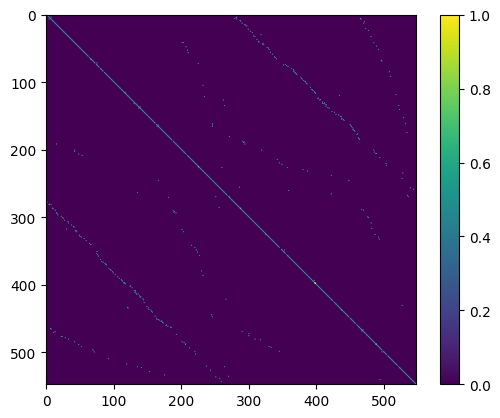

In [13]:
match_threshold = 0.5
thrs_output = np.zeros_like(Output)
thrs_output[Output > match_threshold] = 1

plt.imshow(thrs_output)
#plt.imshow(Output)
plt.colorbar()

In [14]:
matches = np.argwhere( ((thrs_output * WithinSession)) == True)
matches[:10]

array([[  1, 278],
       [  4, 282],
       [  5, 281],
       [  6, 279],
       [  6, 465],
       [  7, 282],
       [  7, 466],
       [  9, 287],
       [ 10, 288],
       [ 11, 471]], dtype=int64)